# Load Library

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [42]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, get_LOMIA_results
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup, draw_hexbin, draw_jointplot
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [130]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict = 
    {
            'correlation': 0,
            'subgroup_col_name': 'SEX',
            'marginal_prior': 1,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
) for (i, j) in [(k, round(-1-k, 2)) for k in [-0.7, -0.65, -0.6, -0.55, -0.5, -0.45, -0.4, -0.35, -0.3][1:2]]}
# ) for i in [-0.5, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][2:3]}

[0, 1]
{0: {(0, 1): 10312, (0, 0): 2187, (1, 1): 2188, (1, 0): 10313}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


In [131]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.65, -0.35RPAREN


In [132]:
experiment = list(experiments.values())[0]
experiment.confidence_array = get_confidence_array(experiment, experiment.X_test, experiment.y_te, experiment.clf)
sens_pred, case_indices = CSMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
case_2_indices = case_indices[2]
experiment.confidence_array_case_2 = experiment.confidence_array[case_2_indices, :]
experiment.X_case_2 = experiment.X_test.loc[case_2_indices].copy().reset_index(drop=True)
experiment.y_case_2 = experiment.y_te.ravel()[case_2_indices]
experiment.sens_val_ground_truth = experiment.X_test[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()
experiment.sens_pred_CSMIA = sens_pred


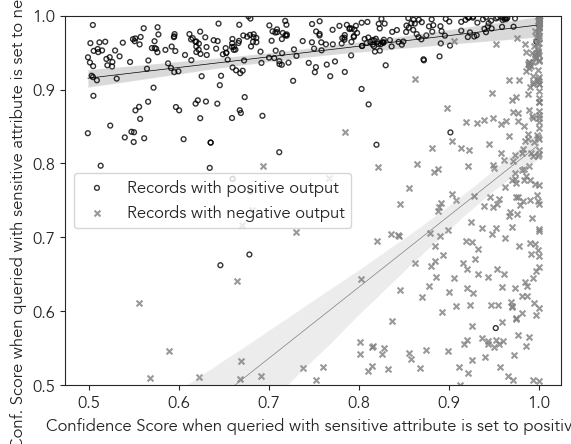

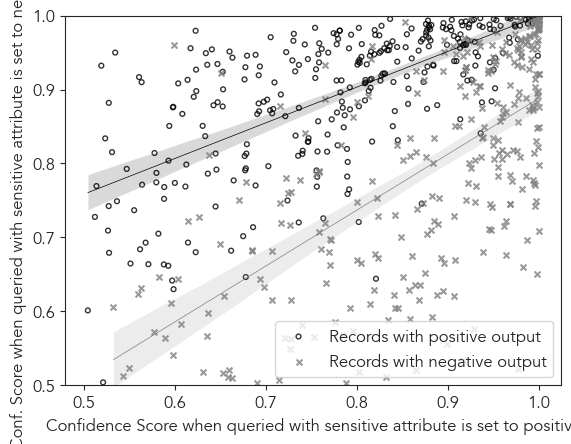

In [214]:
conditions =  [{'SEX': i} for i in range(2)]
for i, condition in enumerate(conditions):
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    draw_confidence_array_scatter(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices], num_points=300, style_fun=None)

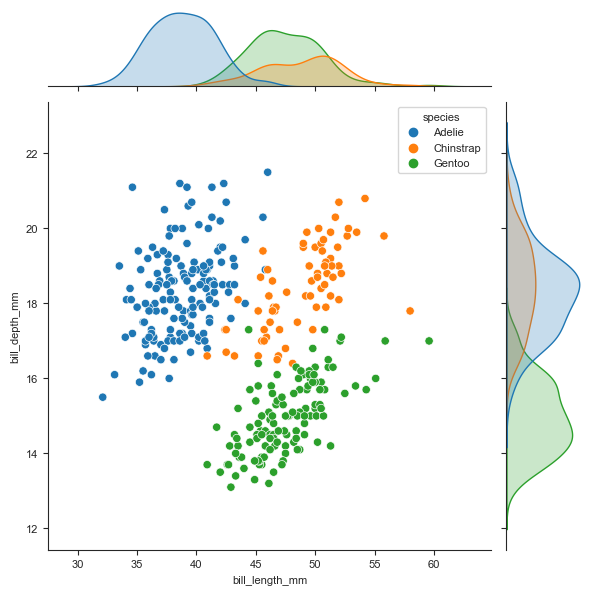

In [114]:
sns.jointplot(data=sns.load_dataset("penguins"), x="bill_length_mm", y="bill_depth_mm", hue="species")

In [136]:
conditions =  [{'SEX': i} for i in range(2)] + [{'RAC1P': 0}]
for i, condition in enumerate(conditions):
    case_2_indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[case_2_indices], experiment.y_case_2[case_2_indices])
    print(angular_difference)

0.8743662249672354
0.29806275022287904
0.47009992700946535


In [239]:
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 15

In [189]:
from matplotlib.colors import LinearSegmentedColormap

<Figure size 500x600 with 0 Axes>

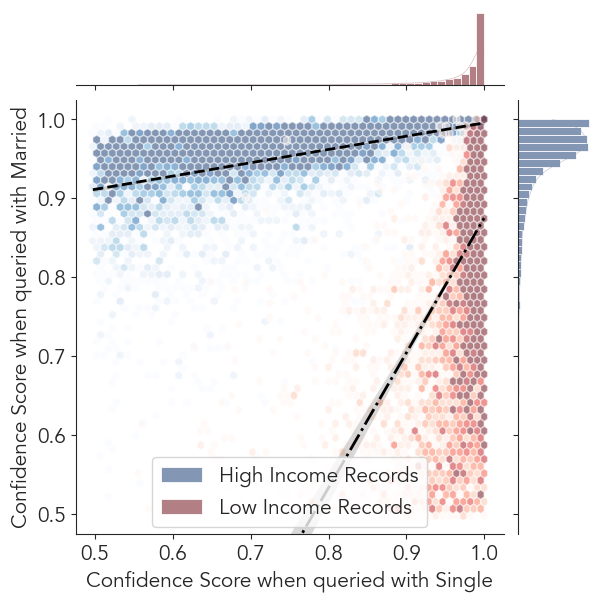

<Figure size 500x600 with 0 Axes>

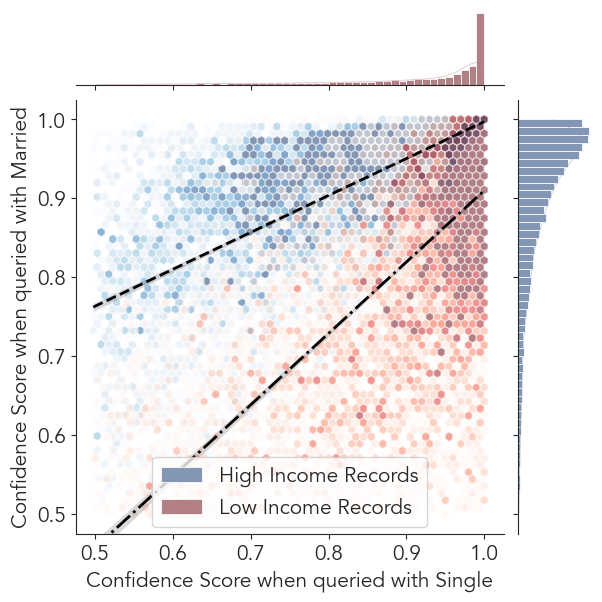

<Figure size 500x600 with 0 Axes>

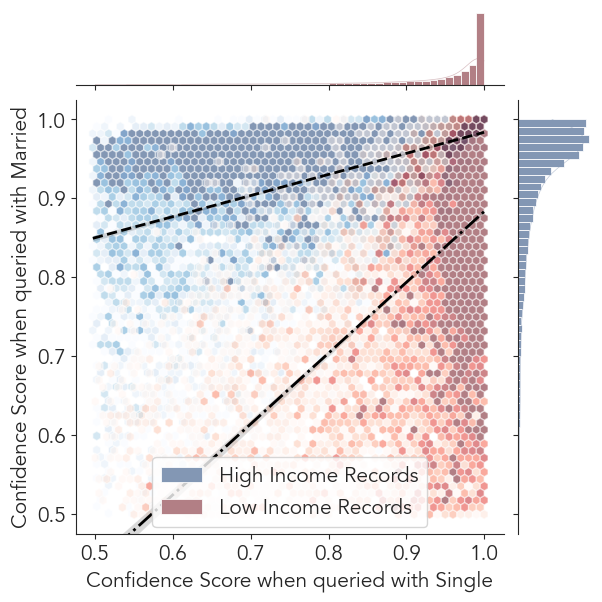

In [241]:
conditions =  [{'SEX': i} for i in range(2)] + [{'RAC1P': 0}]
for i, condition in enumerate(conditions):
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    draw_jointplot(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])

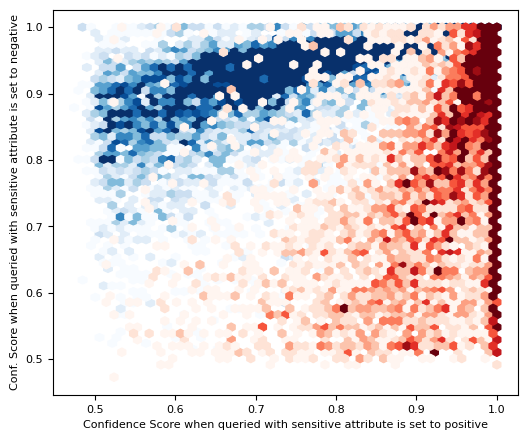

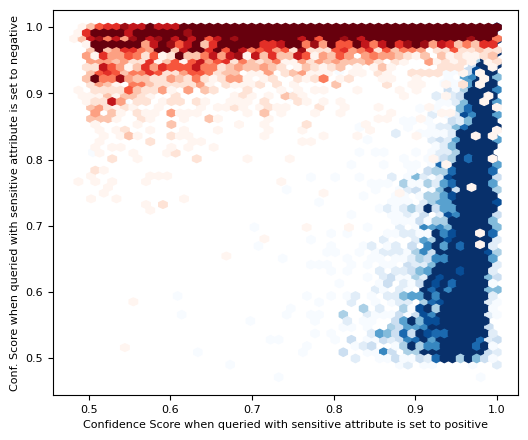

In [38]:
conditions =  [{'SEX': i} for i in range(2)]
for i, condition in enumerate(conditions):
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    draw_hexbin(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])

In [17]:
experiment.confidence_array[:, 1].shape

(50000,)

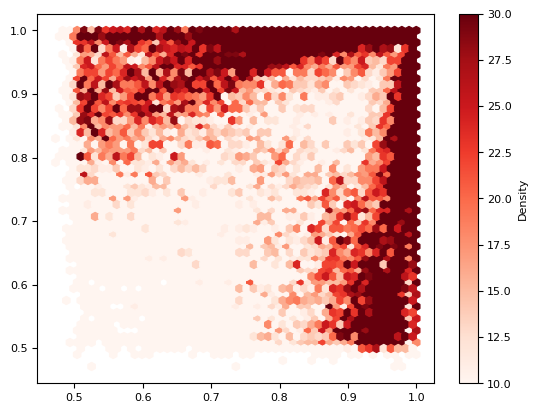

In [16]:
conditions =  [{'SEX': i} for i in range(2)][1:]
colors = ['blue', 'red']
for i, condition in enumerate(conditions):
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    y_array = experiment.y_case_2[indices]
    y_values = np.array(experiment.ds.ds.meta["y_values"]).astype(int)
    indices_by_y_values = {y_value: np.where(y_array.ravel() == y_value)[0] for y_value in y_values}

    for y_value in [1, 0][1:]:
        plt.hexbin(experiment.confidence_array[:, 1], experiment.confidence_array[:, 0], gridsize=50, cmap='Reds', mincnt=1, vmin=10, vmax=30, label='Set 1')
        # sns.kdeplot(x = experiment.confidence_array[indices_by_y_values[y_value], 1][:300], y = experiment.confidence_array[indices_by_y_values[y_value], 0][:300], shade=True, shade_lowest=False, color=colors[y_value])
        # sns.regplot(x = confidence_array[indices_by_y_values[y_value], 1][:num_points], y = confidence_array[indices_by_y_values[y_value], 0][:num_points], marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5), scatter_kws=scatter_kws_list.pop(), label=y_names[y_value])
        plt.colorbar(label='Density')
        plt.show()

In [18]:
experiment.confidence_array[indices][indices_by_y_values[y_value], 1].shape

(5935,)

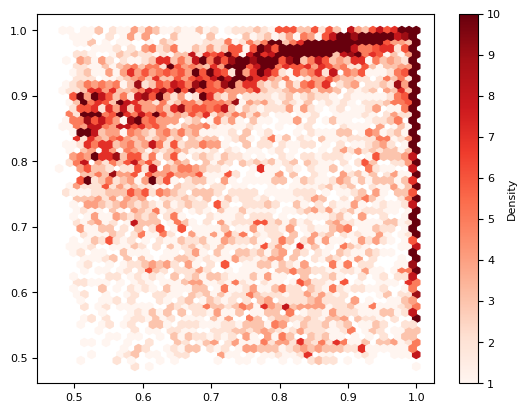

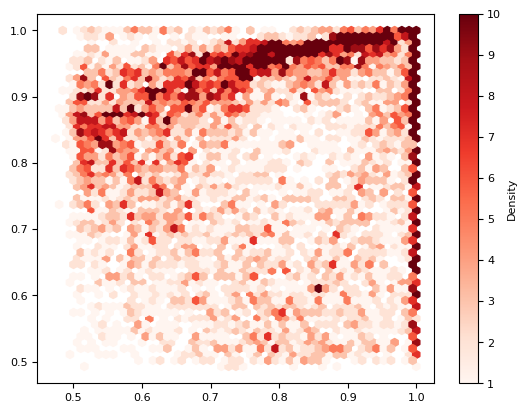

In [22]:
conditions =  [{'SEX': i} for i in range(2)][:1]
colors = ['blue', 'red']
for i, condition in enumerate(conditions):
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    y_array = experiment.y_case_2[indices]
    y_values = np.array(experiment.ds.ds.meta["y_values"]).astype(int)
    indices_by_y_values = {y_value: np.where(y_array.ravel() == y_value)[0] for y_value in y_values}

    for y_value in [1, 0]:
        plt.hexbin(experiment.confidence_array[indices][indices_by_y_values[y_value], 1], experiment.confidence_array[indices][indices_by_y_values[y_value], 0], gridsize=50, cmap='Reds', mincnt=1, vmin=1, vmax=10, label='Set 1')
        # sns.kdeplot(x = experiment.confidence_array[indices_by_y_values[y_value], 1][:300], y = experiment.confidence_array[indices_by_y_values[y_value], 0][:300], shade=True, shade_lowest=False, color=colors[y_value])
        # sns.regplot(x = confidence_array[indices_by_y_values[y_value], 1][:num_points], y = confidence_array[indices_by_y_values[y_value], 0][:num_points], marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5), scatter_kws=scatter_kws_list.pop(), label=y_names[y_value])
        plt.colorbar(label='Density')
        plt.show()

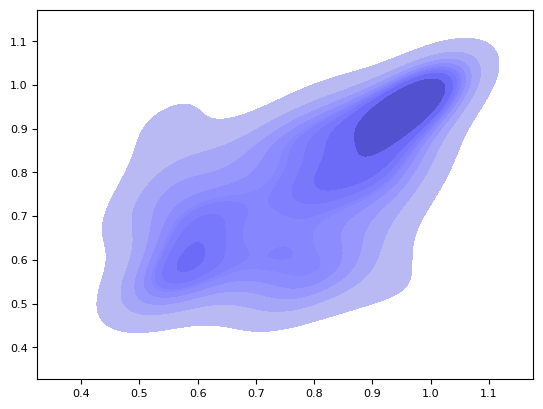

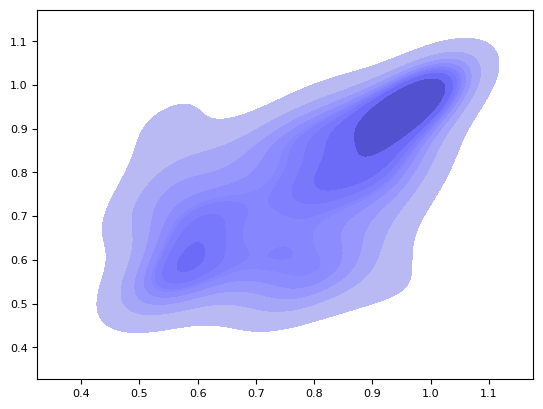

In [25]:
conditions =  [{'SEX': i} for i in range(2)]
colors = ['blue', 'red']
for i, condition in enumerate(conditions):
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    y_array = experiment.y_case_2[indices]
    y_values = np.array(experiment.ds.ds.meta["y_values"]).astype(int)
    indices_by_y_values = {y_value: np.where(y_array.ravel() == y_value)[0] for y_value in y_values}

    for y_value in [1, 0][1:]:
        sns.kdeplot(x = experiment.confidence_array[indices_by_y_values[y_value], 1][:300], y = experiment.confidence_array[indices_by_y_values[y_value], 0][:300], shade=True, shade_lowest=False, color=colors[y_value])
        # sns.regplot(x = confidence_array[indices_by_y_values[y_value], 1][:num_points], y = confidence_array[indices_by_y_values[y_value], 0][:num_points], marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5), scatter_kws=scatter_kws_list.pop(), label=y_names[y_value])
        plt.show()

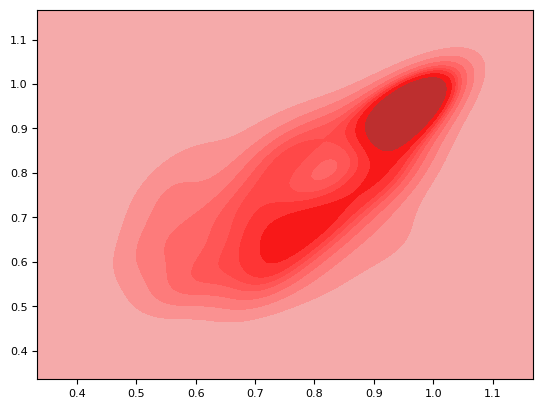

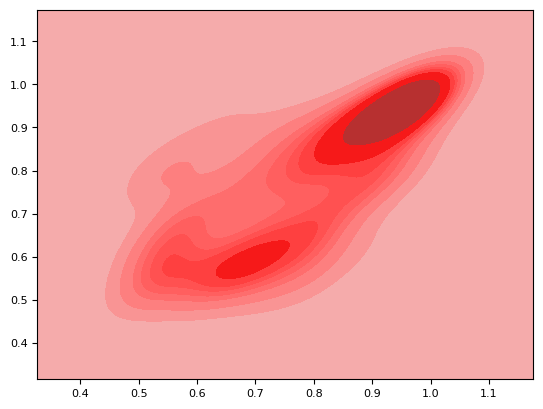

In [33]:
conditions =  [{'SEX': i} for i in range(2)]
colors = ['blue', 'red']
for i, condition in enumerate(conditions):
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    y_array = experiment.y_case_2[indices]
    y_values = np.array(experiment.ds.ds.meta["y_values"]).astype(int)
    indices_by_y_values = {y_value: np.where(y_array.ravel() == y_value)[0] for y_value in y_values}

    for y_value in [1, 0][:1]:
        sns.kdeplot(x = experiment.confidence_array[indices_by_y_values[y_value], 1][:300], y = experiment.confidence_array[indices_by_y_values[y_value], 0][:300], shade=True, shade_lowest=True, color=colors[y_value])
        # sns.regplot(x = confidence_array[indices_by_y_values[y_value], 1][:num_points], y = confidence_array[indices_by_y_values[y_value], 0][:num_points], marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5), scatter_kws=scatter_kws_list.pop(), label=y_names[y_value])
        plt.show()

In [ ]:
import seaborn as sns

# Create a 2D density plot for the first set of points
plt.figure(figsize=(10, 6))
sns.kdeplot(x=x_values_0, y=y_values_0, cmap='Blues', shade=True, shade_lowest=False, label='Set 0')

# Create a 2D density plot for the second set of points
sns.kdeplot(x=x_values_1, y=y_values_1, cmap='Reds', shade=True, shade_lowest=False, label='Set 1')

# Set labels and title
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('2D Density Plot of Two Sets of Points')
plt.legend()

# Show the plot
plt.show()


In [404]:
correlation_vs_ang_diff = {}
sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
temp_df = experiment.X_train.copy()
temp_df[f'{experiment.sensitive_column}_1'] = experiment.sens_pred_CSMIA
conditions =  [{'SEX': i} for i in range(2)]
for i, condition in enumerate(conditions):
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    
    correlation_prediction = get_corr_btn_sens_and_out_per_subgroup(experiment, temp_df, experiment.y_tr, condition)
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
    correlation_vs_ang_diff[fcondition] = {}
    correlation_vs_ang_diff[fcondition]['correlation'] = correlation
    correlation_vs_ang_diff[fcondition]['correlation_prediction'] = correlation_prediction
    # correlation_vs_ang_diff[fcondition]['mutual_info'] = mutual_info
    correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference

In [405]:
correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

In [377]:
correlation_vs_ang_diff_df

,correlation,correlation_prediction,angular_difference,CSMIA_attack_accuracy,LOMIA_attack_accuracy,baseline_attack_accuracy
{},-0.241229,-0.196957,0.115857,0.594901,0.619789,51.4535
{'ST': 0},0.000000,0.658961,-0.170662,0.553000,0.538000,49.8328
{'ST': 1},-0.007849,0.533209,-0.024537,0.562257,0.639105,44.9541
{'ST': 2},-0.019000,0.761357,-0.193907,0.510500,0.491000,46.8584
{'ST': 3},-0.027007,0.510543,-0.107850,0.576974,0.567763,52.9172
{'ST': 4},-0.039000,0.333000,-0.079379,0.536000,0.515500,50.1673
{'ST': 5},-0.049000,0.372272,-0.121616,0.540500,0.545500,50.8406
{'ST': 6},-0.059000,0.805487,-0.331418,0.513000,0.474000,44.0263
{'ST': 7},-0.063470,0.363839,-0.106313,0.585432,0.611981,44.8276
{'ST': 8},-0.079000,0.576655,-0.207083,0.512000,0.491500,30.5556


In [243]:
def plot_comparison(correlation_vs_ang_diff_df, x_axis_col_name='correlation', y_axis_col_name='attack_accuracy'):
    arr = correlation_vs_ang_diff_df[[x_axis_col_name, y_axis_col_name]].to_numpy()

    x_values = [item[0] for item in arr]
    y_values = [item[1] for item in arr]

    # Creating the scatter plot
    fig, ax = plt.subplots()
    plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
    # plt.title('Scatter Plot of Correlation vs Angular Difference')
    plt.xlabel(f'{x_axis_col_name.replace("_", " ")}')
    plt.ylabel(f'{y_axis_col_name}')
    # plt.xlim(-0.5, 0.025)
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # sns.despine()
    plt.show()


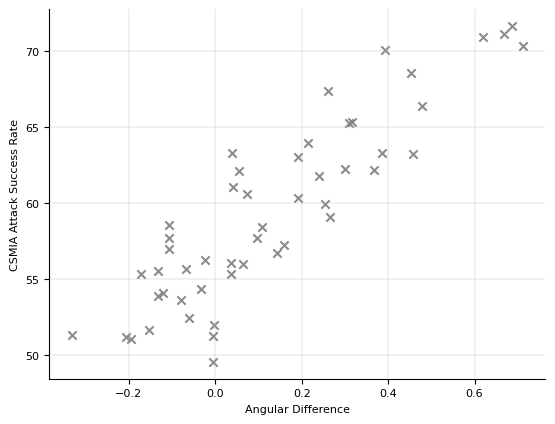

In [344]:
arr = correlation_vs_ang_diff_df[['angular_difference', "CSMIA_attack_accuracy"]].to_numpy()

x_values = [item[0] for item in arr]
y_values = [item[1] for item in arr]

# Creating the scatter plot
fig, ax = plt.subplots()
plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
# plt.title('Scatter Plot of Correlation vs Angular Difference')
plt.xlabel('Angular Difference')
plt.ylabel(f'CSMIA Attack Success Rate')
# plt.xlim(-0.5, 0.025)
plt.grid(True, linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# sns.despine()
plt.show()

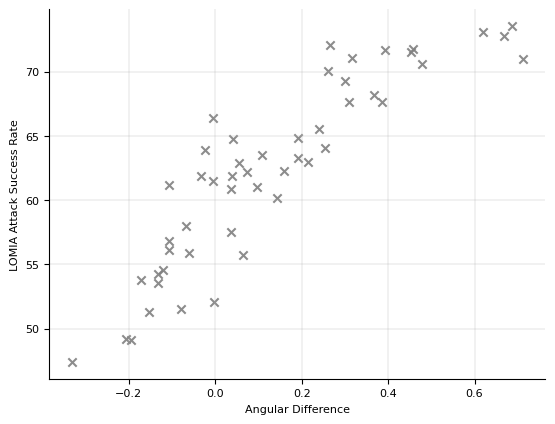

In [343]:
arr = correlation_vs_ang_diff_df[['angular_difference', "LOMIA_attack_accuracy"]].to_numpy()

x_values = [item[0] for item in arr]
y_values = [item[1] for item in arr]

# Creating the scatter plot
fig, ax = plt.subplots()
plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
# plt.title('Scatter Plot of Correlation vs Angular Difference')
plt.xlabel('Angular Difference')
plt.ylabel(f'LOMIA Attack Success Rate')
# plt.xlim(-0.5, 0.025)
plt.grid(True, linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# sns.despine()
plt.show()

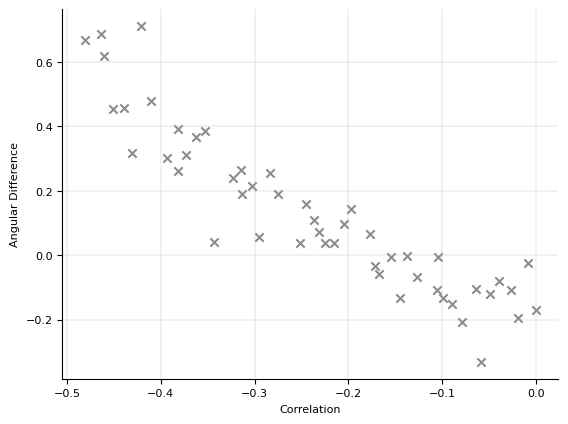

In [345]:
arr = correlation_vs_ang_diff_df[['correlation', "angular_difference"]].to_numpy()

x_values = [item[0] for item in arr]
y_values = [item[1] for item in arr]

# Creating the scatter plot
fig, ax = plt.subplots()
plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
# plt.title('Scatter Plot of Correlation vs Angular Difference')
plt.xlabel('Correlation')
plt.ylabel(f'Angular Difference')
# plt.xlim(-0.5, 0.025)
plt.grid(True, linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# sns.despine()
plt.show()

In [318]:
attacks = ['CSMIA', 'LOMIA']
metrics = [kendalltau, spearmanr]
metric_name_dict = {
    kendalltau: 'Kendall Tau',
    spearmanr: 'Spearman R'
}

ranking_perf_dict = {}
for attack in attacks:
    ranking_perf_dict[attack] = {}
    for metric in metrics:
        ranking_perf_dict[attack][metric_name_dict[metric]] = {}

        for dia in ['angular_difference', 'baseline_attack_accuracy']:
            ranking_perf = metric(correlation_vs_ang_diff_df[[f'{attack}_attack_accuracy']].to_numpy(), correlation_vs_ang_diff_df[[dia]].to_numpy())
            ranking_perf_dict[attack][metric_name_dict[metric]][dia] = f'{round(ranking_perf.statistic, 4)} ({ranking_perf.pvalue:.2e})'
            # x_values = correlation_vs_ang_diff[[f'{attack}_attack_accuracy']].to_numpy()
            # ranking_perf_dict[attack][metric][dia] = metric(x_values, x_values)

In [319]:
ranking_perf_dict

{'CSMIA': {'Kendall Tau': {'angular_difference': '0.6914 (1.39e-12)',
   'baseline_attack_accuracy': '-0.0759 (4.37e-01)'},
  'Spearman R': {'angular_difference': '0.8767 (7.23e-17)',
   'baseline_attack_accuracy': '-0.1225 (3.97e-01)'}},
 'LOMIA': {'Kendall Tau': {'angular_difference': '0.7579 (8.30e-15)',
   'baseline_attack_accuracy': '-0.0931 (3.40e-01)'},
  'Spearman R': {'angular_difference': '0.9104 (5.06e-20)',
   'baseline_attack_accuracy': '-0.1275 (3.77e-01)'}}}

In [315]:
f"{ranking_perf.pvalue:.2e}"

'1.39e-12'

In [309]:
ranking_perf_dict

{'CSMIA': {'<function kendalltau at 0x1277929d0>': {'angular_difference': SignificanceResult(statistic=0.6914285714285714, pvalue=1.3900963709598425e-12),
   'baseline_attack_accuracy': SignificanceResult(statistic=-0.07591836734693877, pvalue=0.43660923632935034)},
  '<function spearmanr at 0x1277928b0>': {'angular_difference': SignificanceResult(statistic=0.8766866746698678, pvalue=7.232312722148806e-17),
   'baseline_attack_accuracy': SignificanceResult(statistic=-0.1224969987995198, pvalue=0.39673069234463554)}},
 'LOMIA': {'<function kendalltau at 0x1277929d0>': {'angular_difference': SignificanceResult(statistic=0.7578604143440391, pvalue=8.3035518660684e-15),
   'baseline_attack_accuracy': SignificanceResult(statistic=-0.0930992319345048, pvalue=0.3402724081290214)},
  '<function spearmanr at 0x1277928b0>': {'angular_difference': SignificanceResult(statistic=0.9103699971410856, pvalue=5.0555002063792164e-20),
   'baseline_attack_accuracy': SignificanceResult(statistic=-0.1275420

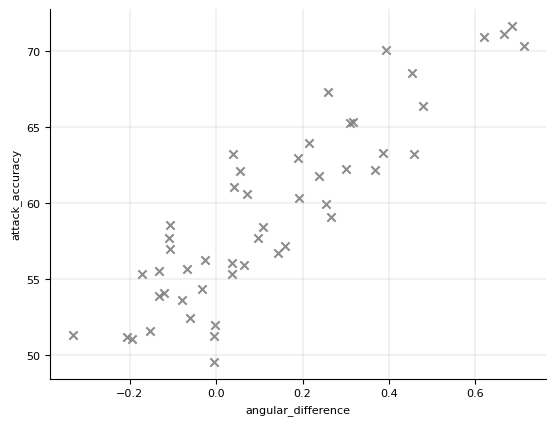

In [273]:
plot_comparison(correlation_vs_ang_diff_df, 'angular_difference', 'attack_accuracy')

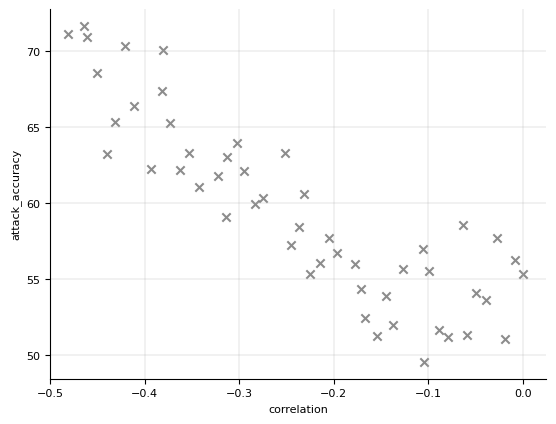

In [241]:
plot_comparison(correlation_vs_ang_diff_df)

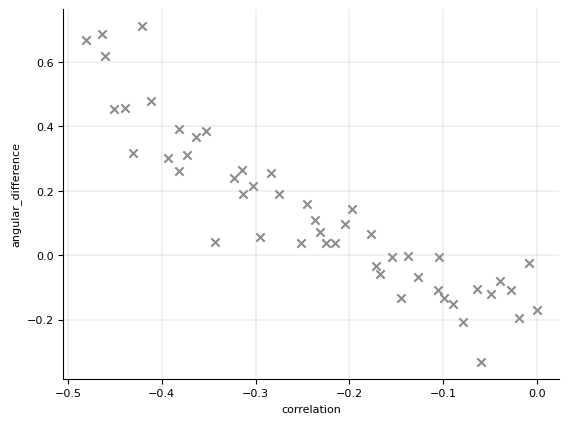

In [246]:
plot_comparison(correlation_vs_ang_diff_df, y_axis_col_name='angular_difference')

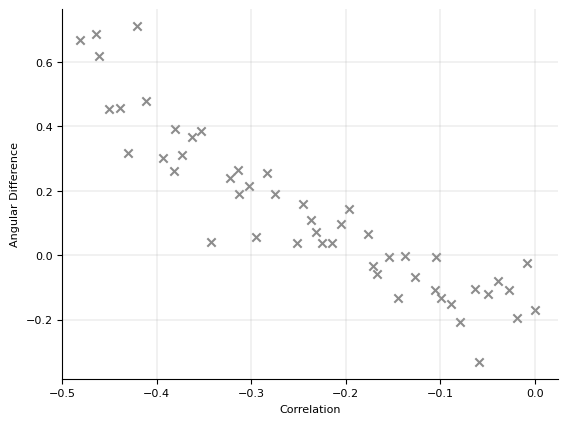

In [167]:
correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')
arr = correlation_vs_ang_diff_df[['correlation', 'angular_difference']].to_numpy()

x_values = [item[0] for item in arr]
y_values = [item[1] for item in arr]

# Creating the scatter plot
fig, ax = plt.subplots()
plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
# plt.title('Scatter Plot of Correlation vs Angular Difference')
plt.xlabel('Correlation')
plt.ylabel('Angular Difference')
plt.xlim(-0.5, 0.025)
plt.grid(True, linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# sns.despine()
plt.show()

In [346]:
def draw_conf_scatter_for_state(state_index=0, num_points=300):
    indices = get_indices_by_group_condition(experiment.X_case_2, {'ST': state_index})
    draw_confidence_array_scatter(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices], num_points)

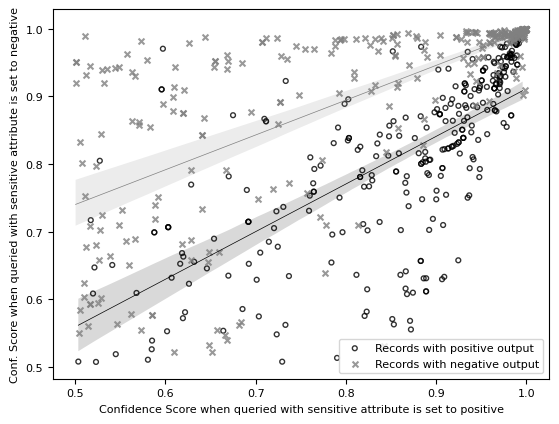

In [352]:
draw_conf_scatter_for_state()

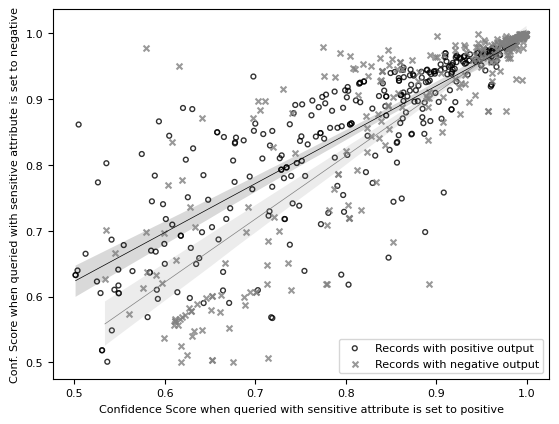

In [353]:
draw_conf_scatter_for_state(state_index=25)

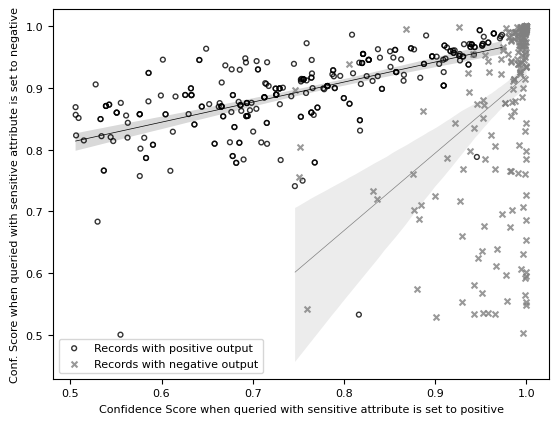

In [354]:
draw_conf_scatter_for_state(state_index=50)